# <a name="top"></a>SWPLA PDDA 2020 Synthetic Sonic Log Generation Contest

**Author:** Ben Dowdell

**Date:** March XX, 2020

**Purpose:** To minimize RMSE in predicting Sonic logs (compressional & shear) from a suite of standard well logs

**v2 notebook goes with 'dowdell_submission_v2.csv'**

**Outline**

* [1. Initial Set-Up](#initial-setup)
** [1a. Standard Imports](#standard-imports)
** [1b. Sklearn Imports](#sklearn-imports)
** [1c. Helper Function Definitions](#helper-funcs)
* [2. Read Data](#read-data)
* [3. Inspect Data](#inspect-data)
* [4. EDA](#eda)
* [5. Baseline Model](#baseline)
* [6. DTC & DTS Model Train/Test](#model)
* [7. Blind Test QC & Blind Test Prediction Output](#blind-test)
* [8. Summary](#summary)

### Data Decription
#### Files
#### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


#### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

## <a name="initial-setup"></a>1. Initial Set-Up

Back to [top](#top)

### <a name="standard-imports"></a> 1a. Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from pprint import pprint

random_state = 42
rng = np.random.RandomState(seed=42)

%matplotlib inline

### <a name="sklearn-imports"></a>1b. Scikit-learn & Associated Imports

In [2]:
# Preprocessing utilities
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE, f_regression

# Model k-fold Cross Validation score for generalization evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering Models
from sklearn.cluster import KMeans, DBSCAN

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Pipeline
from sklearn.pipeline import make_pipeline

# XGBoost
import xgboost as xgb #for XGBRegressor

# Yellowbrick tools for model analysis
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.features import PCA as PCA_yb
from yellowbrick.target import FeatureCorrelation
from yellowbrick.model_selection import FeatureImportances, ValidationCurve

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Statsmodels imports

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

### <a name="helper-funcs"></a>1c. Helper Function Definitions

Helper function to plot data histograms

In [4]:
def plot_data_distributions(df):
    """Plot histograms of each curve
    
    Paramters:
    df (pandas.DataFrame) : Input data frame containing log curves
    
    Returns:
    matplotlib.figure.Figure
    """
    flag = 0
    n_subplots = len(df.columns.to_list())
    if n_subplots % 2 == 0:
        n_rows = 2
        n_cols = n_subplots // n_rows
    elif n_subplots % 3 == 0:
        n_rows = 3
        n_cols = n_subplots // n_rows
    else:
        n_cols = n_subplots // 2
        n_rows = n_subplots // n_cols
        n_rows += n_subplots % n_cols
        n_blank = (n_rows * n_cols) - n_subplots
        flag = 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,8))
    if flag == 1:
        axes[-1,-n_blank].axis('off')
    for ax, col in zip(axes.flatten(), df.columns.tolist()):
        ax.hist(df[col])
        if 'HR' in col:
            ax.set_xscale('log')
        ax.set_title('{} Histogram'.format(col))
    plt.tight_layout()
    return fig

Helper function to plot well curves in a normal log display

In [5]:
def plot_well_curves(data):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data (pandas.DataFrame) : Input data frame containing the well log curves, one per column
    
    curve_names (list) : A list containing the column name of each well log curve in the input data frame
    
    Returns:
    matplotlib.figure.Figure
    """
    # get the column names as a list
    curve_names = data.columns.tolist()
    
    # create the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data[curve], data.index, color='k')
        else:
            ax.plot(data[curve], data.index, color='k')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS'] or 'DT' in curve:
            ax.set_title(curve, fontdict={'color':'r'})
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
    ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to remove outliers from log curves using standard deviation from median value in a window

In [6]:
def filter_curves(data, window, n_std):
    """
    Takes a data frame containing well log curves and filters outliers based on n-standard deviations
    from a median filtered version of the data.
    
    Parameters:
    data (pandas.DataFrame) : The input data frame containing data to be filtered.  Each column is a well log curve.
    
    window (int) : The size of the window to use in creating a median filtered curve (recommend 33)
    
    n_std (int) : The number of +/- standard deviations to use in considering outliers (recommend 2)
    
    Returns:
    df_clean (pandas.DataFrame) : The filtered well curves
    df_outliers (pandas.DataFrame) : The outlier data points removed by the filtering operation
    """
    # create a copy of the original data
    df_copy = data.copy()
    
    # create a data frame containing median-filtered version of the data
    df_medfilter = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_medfilter[col] = df_copy[col].rolling(window, min_periods=1, center=True).median()
        
    # create a data frame containing standard deviation of the data
    df_stddev = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_stddev[col] = df_medfilter[col].rolling(window, min_periods=1, center=True).std()
        
    # create a data frame containing the cleaned version of the data using standard deviation from the median filtered data
    # and create a data frame containing the removed outliers
    df_clean = pd.DataFrame()
    df_outliers = pd.DataFrame()
    for col in df_copy.columns.tolist():
        upper = df_medfilter[col] + df_stddev[col]*n_std
        lower = df_medfilter[col] - df_stddev[col]*n_std
        df_clean[col] = df_copy[col].where((df_copy[col] <= upper) & (df_copy[col] >= lower))
        #df_clean[col] = df_clean[col].interpolate(limit_area='inside')
        df_outliers[col] = df_copy[col].where(df_clean[col] != df_copy[col])
    
    return df_clean, df_outliers

Helper function to compare raw versus filtered logs

In [7]:
def qc_curve_filt(data_raw, data_cleaned, *args):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data_raw (pandas.DataFrame) : Input data frame containing the well log curves, one log per column
    
    data_cleaned (pandas.DataFrame) : Input data frame containing filtered log curves, one log per column
    
    *args (pandas.DataFrame) : Optional data frame containing outliers
    
    Returns:
    matplotlib.figure.Figure
    """
    
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = data_raw.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.semilogx(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.semilogx(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        else:
            ax.plot(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.plot(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.plot(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to compare individual predictors to DTC & DTS

In [8]:
def compare_curves(predictor, dtc, dts):
    """
    Takes a predictor curve and plots it against both response variables, DTC & DTS
    
    Parameters:
    predictor (pandas.core.series.Series) : Independent Variable to compare, assumes either a column from a pandas DataFrame or ndarray-like
    
    dtc (pandas.core.series.Series) : DTC curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    dts (pandas.core.series.Series) : DTS curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    Returns:
    matplotlib.figure.Figure
    """
    fig = plt.figure(figsize=(20,10), linewidth=5, edgecolor='k')
    name = predictor.name
    fig.suptitle('{} curve comparison to DTC & DTS'.format(name), fontsize=20)
    
    ax1 = fig.add_subplot(2,2,1)
    if name == 'HRD':
        ax1.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax1.plot(predictor.index, predictor.values, 'k', lw=3)
    ax1c = ax1.twinx()
    ax1c.plot(dtc.index, dtc.values, 'r', lw=2)
    ax1c.invert_yaxis()
    ax1.set_ylabel(name)
    ax1c.set_ylabel('DTC', fontdict={'color':'r'})
    ax1.grid(False)
    ax1c.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 = sns.scatterplot(x=predictor, y=dtc)
    if name == 'HRD':
        ax2.set_xscale('log')
    ax2.set_xlabel(name)
    ax2.set_ylabel('DTC')
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    if name == 'HRD':
        ax3.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax3.plot(predictor.index, predictor.values, 'k', lw=3)
    ax3c = ax3.twinx()
    ax3c.plot(dts.index, dts.values, 'r', lw=2)
    ax3c.invert_yaxis()
    ax3.set_ylabel(name)
    ax3c.set_ylabel('DTS', fontdict={'color':'r'})
    ax3.grid(False)
    ax3c.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 = sns.scatterplot(x=predictor, y=dts)
    if name == 'HRD':
        ax4.set_xscale('log')
    ax4.set_xlabel(name)
    ax4.set_ylabel('DTS')
    ax4.grid(False)
    
    return fig

Helper function to plot Vp versus Vs using well known rock physics templates

In [9]:
def plot_vp_vs(x='DTC', y='DTS', color='index', df=None):
    """
    Plots measured Vp & Vs against well-known rock physics trends
    
    Parameters:
    x (pandas.Series) : Input DTC values, in us/ft
    y (pandas.Series) : Input DTS values, in us/ft
    color (str) : Input variable for coloring scatter plot, acceptable values are 'index' and df column names
    df (pandas.DataFrame) : Input data frame containing x & y
    
    Returns:
    matplotlib.figure.Figure
    """
    
    vp_ft_s = 1e6 / df[x]
    vp_m_s = vp_ft_s /  3.281
    vp_km_s = vp_m_s / 1000
    
    vs_ft_s = 1e6 / df[y]
    vs_m_s = vs_ft_s / 3.281
    vs_km_s = vs_m_s / 1000
    
    xvp = np.arange(start=0, stop=8, step=0.1)
    
    df_keys = df.columns.to_list()
    color_mapping = dict()
    color_mapping['index'] = df.index
    
    for key in df_keys:
        if key not in color_mapping:
            color_mapping[key] = df[key]
    
    Vs_castagna_ls = np.multiply(-0.05508, np.power(xvp, 2)) + np.multiply(1.0168, xvp) - 1.0305
    Vs_castagna_dm = np.multiply(0.5832, xvp) - 0.07776
    Vs_castagna_mudrock = np.multiply(0.8621, xvp) - 1.1724
    Vs_castagna_ss = np.multiply(0.8042, xvp) - 0.8559
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(Vs_castagna_ls, xvp, '--b', lw=2, label='Castagna et al. (1993) Water-saturated Limestone')
    ax.plot(Vs_castagna_dm, xvp, '--c', lw=2, label='Castagna et al. (1993) Water-saturated Dolomite')
    ax.plot(Vs_castagna_mudrock, xvp, '--k', lw=2, label='Castagna et al. (1993) Mudrock line')
    ax.plot(Vs_castagna_ss, xvp, '--r', lw=2, label='Castagna et al. (1993) Water-saturated sandstone')
    im = ax.scatter(vs_km_s, vp_km_s, s=10, c=color_mapping[color], marker='.', cmap='inferno', alpha=0.8)
    ax.set_xlabel('Vs (km/s)')
    ax.set_ylabel('Vp (km/s)')
    ax.set_title('Vp vs. Vs', fontsize=20, fontweight='bold')
    ax.set_xlim([np.nanmin(vs_km_s), np.nanmax(vs_km_s)])
    ax.set_ylim([np.nanmin(vp_km_s), np.nanmax(vp_km_s)])
    ax.legend(loc='upper left')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.invert_yaxis()
    cbar.set_label(f'{color}', fontdict={'fontweight':'bold'})
    
    return fig

Helper function to plot Training Real vs. Training Predicted

In [10]:
def plot_real_vs_pred(y, y_pred, feat_name, split):
    """Function that plots y vs y_pred
    
    Parameters:
    y (ndarray like) : real values
    y_pred (ndarray like) : predicted values
    feat_name (str) : Feature name
    split (str) : Whether this is 'Train', 'Test', or 'Full Log'
    
    returns matplotlib.figure.Figure
    """
    
    o2o = np.linspace(0, np.nanmax(y), len(y))
    
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Real {} vs. Predict'.format(split))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(y.reset_index(drop=True, inplace=False), 'k', lw=2, label='y {}'.format(split))
    ax1.plot(y_pred, 'r', lw=1, label='y_{}_pred'.format(split))
    ax1.set_xlabel('sample no.')
    ax1.set_ylabel(feat_name)
    ax1.set_title('{} Real & Predict'.format(split))
    ax1.legend(loc='best')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(y, y_pred, s=10, marker='.', alpha=0.8)
    ax2.plot(o2o, o2o, 'k', lw=2, label='one-to-one')
    ax2.set_xlabel('{} Real {}'.format(feat_name, split))
    ax2.set_ylabel('{} Predict {}'.format(feat_name, split))
    ax2.legend(loc='best')
    ax2.set_title('{} {} Predict vs. Real'.format(feat_name, split))
    
    return fig

Helper function to find consecutive NaN values and the starting index number
[Consecutive NaN larger than threshold](https://stackoverflow.com/questions46007776/consecutive-nan-larger-than-threshold-in-pandas-dataframe)

In [11]:
def consecutive_nans(index, col, threshold):
    """Function returns the starting index of consecutive NaN's in an input column
    Uses Divakar's answer in above link
    """
    
    thresh = threshold
    
    a = index.values
    b = col.values
    
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0, True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask = (count>=thresh) & np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_num = a[out_idx]
    out_count = count[valid_mask]
    out = range(int(out_num),int(out_num)+int(out_count)-1)
    
    return out

Helper function to plot custom [heatmap](https://github.com/amueller/mglearn/blob/master/mglearn/tools.py)

In [12]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

**Scorer functions for multi-output scoring**

We have multi-target output, so we need a custom scrorer.

r2 is the standard accuracy score.

rmse is the objective score to minimize

In [13]:
r2_scorer = make_scorer(r2_score, multioutput='uniform_average')
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, multioutput='uniform_average', squared=False)

## 2. <a name="read-data"></a>Read in Data

Back to [top](#top)

In [14]:
df_w1 = pd.read_csv('../data/train.csv')

In [15]:
df_w1.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


## 3. <a name="inspect-data"></a>Inspect Data

Back to [top](#top)

In [16]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
CAL     30143 non-null float64
CNC     30143 non-null float64
GR      30143 non-null float64
HRD     30143 non-null float64
HRM     30143 non-null float64
PE      30143 non-null float64
ZDEN    30143 non-null float64
DTC     30143 non-null float64
DTS     30143 non-null float64
dtypes: float64(9)
memory usage: 2.1 MB


All data are type float64

In [17]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,30143.0,-8.394576,129.970219,-999.0,8.05835,8.6250,9.04885,21.0642
CNC,30143.0,-23.692615,157.142679,-999.0,0.12280,0.1936,0.33715,3490.1582
GR,30143.0,38.959845,108.504554,-999.0,17.24875,36.8218,58.34615,1470.2534
HRD,30143.0,3.977690,365.112753,-999.0,0.71770,1.6230,3.15830,10000.0000
HRM,30143.0,1.547299,456.908969,-999.0,0.71205,1.6281,3.28060,60467.7617
PE,30143.0,-17.446739,149.083136,-999.0,0.05310,4.9415,7.85665,28.1064
ZDEN,30143.0,-20.229982,148.809506,-999.0,2.22670,2.4322,2.55135,3.2597
DTC,30143.0,-54.891703,372.858812,-999.0,66.30435,78.3551,107.02250,155.9803
DTS,30143.0,-9.737567,440.314119,-999.0,118.53435,137.6893,182.97315,487.4384


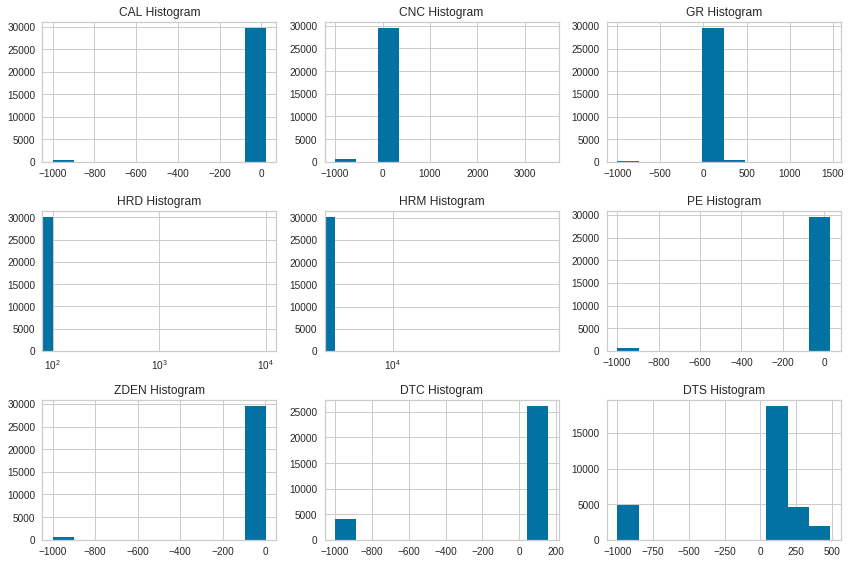

In [18]:
plot_data_distributions(df_w1.dropna())
plt.show()

Samples with value of -999.0 need to be replaced with NaN

In [19]:
df_w1.replace(to_replace=-999.0, value=np.nan, inplace=True)

In [20]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29408.0,0.683437,30.689679,-0.1028,0.127100,0.19850,0.343100,3490.1582
GR,29889.0,47.780541,51.377519,-0.1460,18.026100,37.08220,58.532800,1470.2534
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29464.0,5.173227,4.781088,-0.0232,0.054200,5.04250,7.949700,28.1064
ZDEN,29462.0,2.393818,0.196276,-1.9238,2.234800,2.43960,2.553000,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


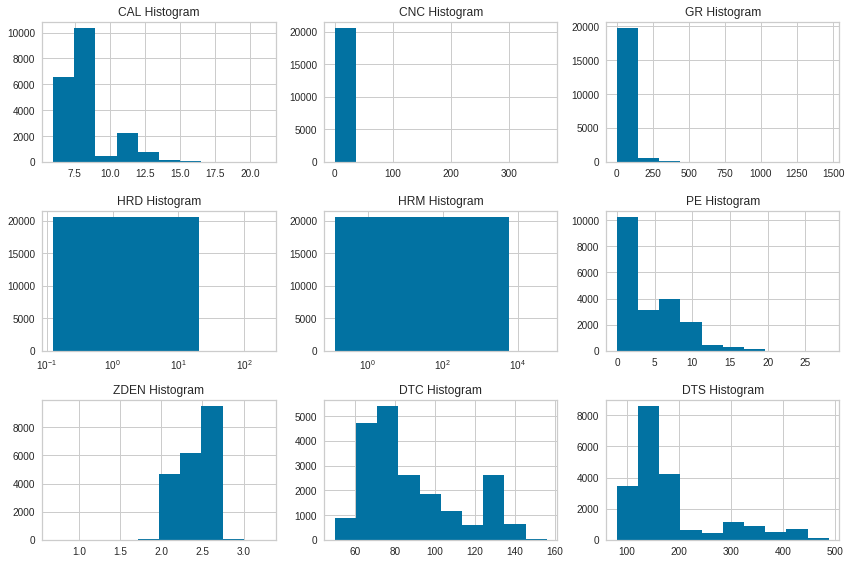

In [21]:
plot_data_distributions(df_w1.dropna())
plt.show()

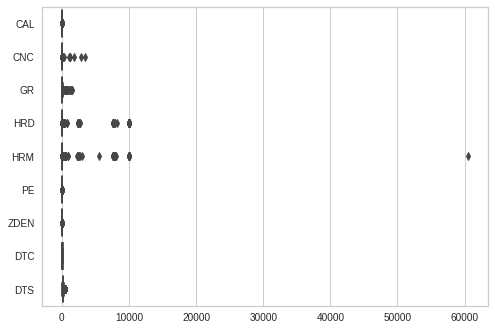

In [22]:
sns.boxplot(data=df_w1, orient='h')

There are some suspicious values here that we will explore in the next step, and lots of outliers according to the boxplot

1. CNC should range from 0.0 to 1.0
1. GR should not have values less than 0.0
1. PE should not have values less than 0.0
1. ZDEN should not have values less than 0.0

## <a name="eda"></a>4) Exploratory Data Analysis (EDA) & Cleaning

Back to [top](#top)

Before making any edits to values, plot the data for visual QC inspection

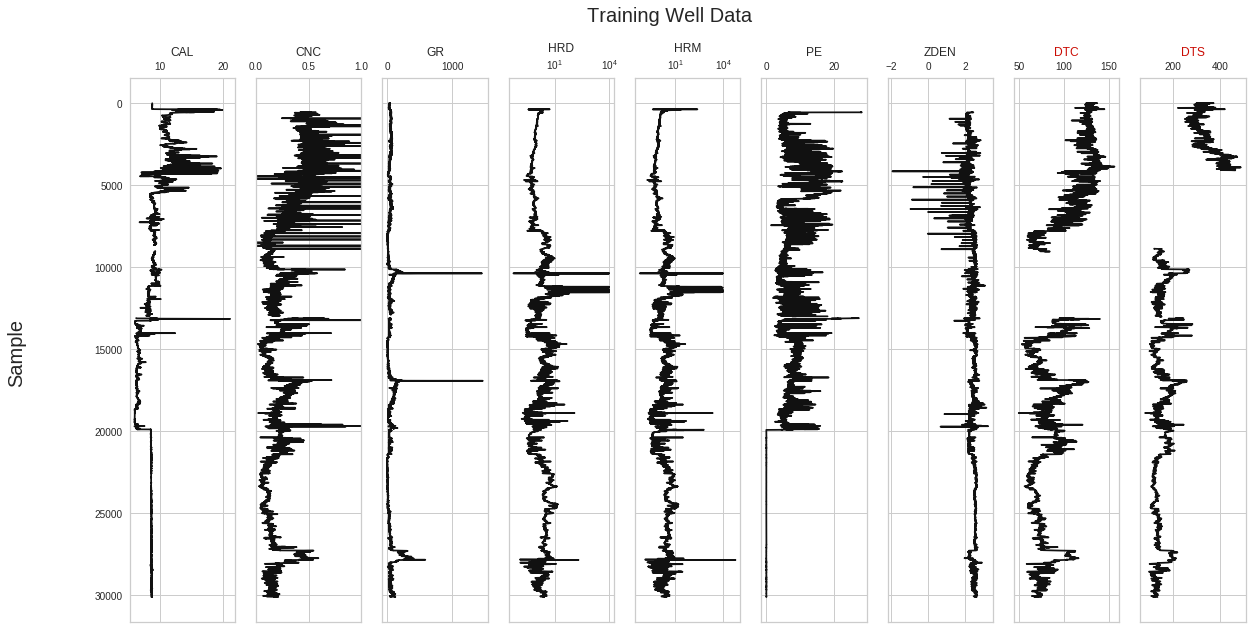

In [23]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

In [24]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29408.0,0.683437,30.689679,-0.1028,0.127100,0.19850,0.343100,3490.1582
GR,29889.0,47.780541,51.377519,-0.1460,18.026100,37.08220,58.532800,1470.2534
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29464.0,5.173227,4.781088,-0.0232,0.054200,5.04250,7.949700,28.1064
ZDEN,29462.0,2.393818,0.196276,-1.9238,2.234800,2.43960,2.553000,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


Limit CNC to range between 0.0 and 1.0

In [25]:
df_w1.loc[df_w1['CNC'] < 0.0, ['CNC']] = np.nan
df_w1.loc[df_w1['CNC'] > 1.0, ['CNC']] = np.nan

Limit GR to range between 0.0 and 300.0

In [26]:
df_w1.loc[df_w1['GR'] < 0.0, ['GR']] = np.nan
df_w1.loc[df_w1['GR'] > 300.0, ['GR']] = np.nan

Limit PE to have values no less than 0.0

In [27]:
df_w1.loc[df_w1['PE'] < 0.0, ['PE']] = np.nan

Limit ZDEN to have values no less than 0.0

In [28]:
df_w1.loc[df_w1['ZDEN'] < 0.0, ['ZDEN']] = np.nan

In [29]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29308.0,0.247144,0.155301,0.0041,0.126800,0.19800,0.340900,0.9997
GR,29685.0,45.468596,40.347602,0.0000,17.867400,36.87760,58.015600,299.9370
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29455.0,5.174812,4.780959,0.0000,0.054200,5.04380,7.950150,28.1064
ZDEN,29454.0,2.394661,0.189292,0.0035,2.234900,2.43970,2.553100,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


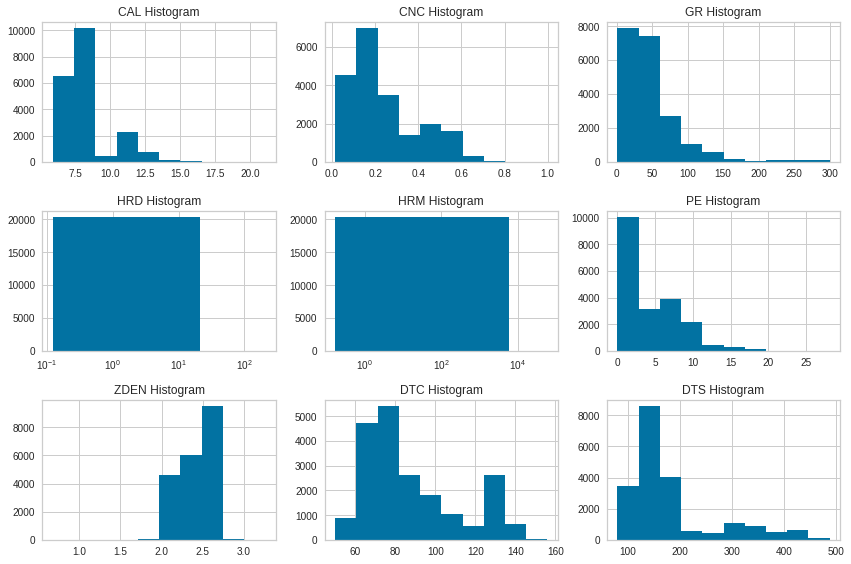

In [30]:
plot_data_distributions(df_w1.dropna())
plt.show()

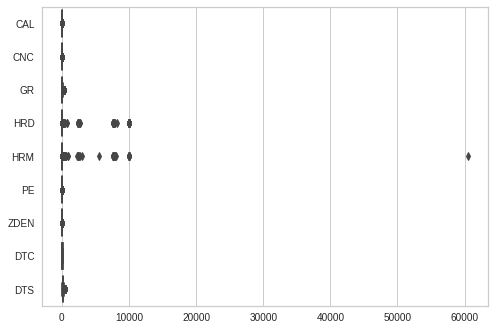

In [31]:
sns.boxplot(data=df_w1, orient='h')

These value ranges are substantially more acceptable.  HRD & HRM are on very different scales, and there are still outliers present, but less severe.

Most of the distributions actually appear to be log-normal.  Let's try applying a log transform and re-plot the distributions

Re-plot the data and visually inspect

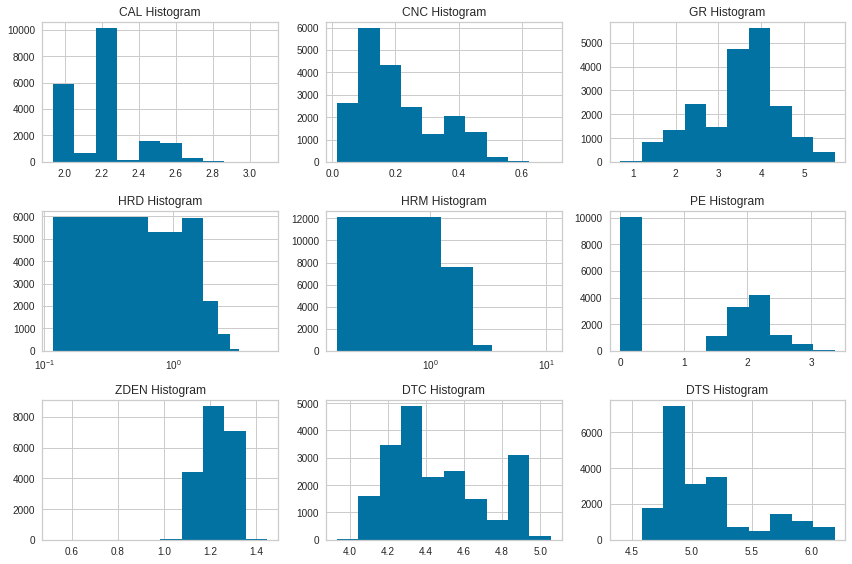

In [36]:
plot_data_distributions(df_w1.dropna().apply(lambda x: np.log(x+1)))
plt.show()

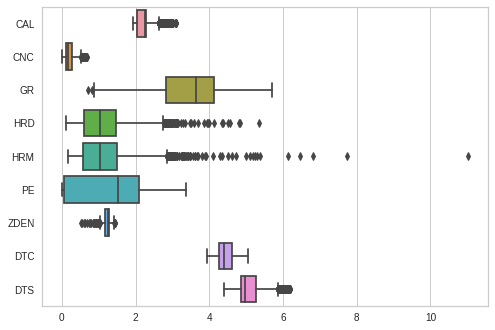

In [38]:
sns.boxplot(data=df_w1.dropna().apply(lambda x: np.log(1+x)), orient='h')

This suggests that most of the distributions tend to be log normal

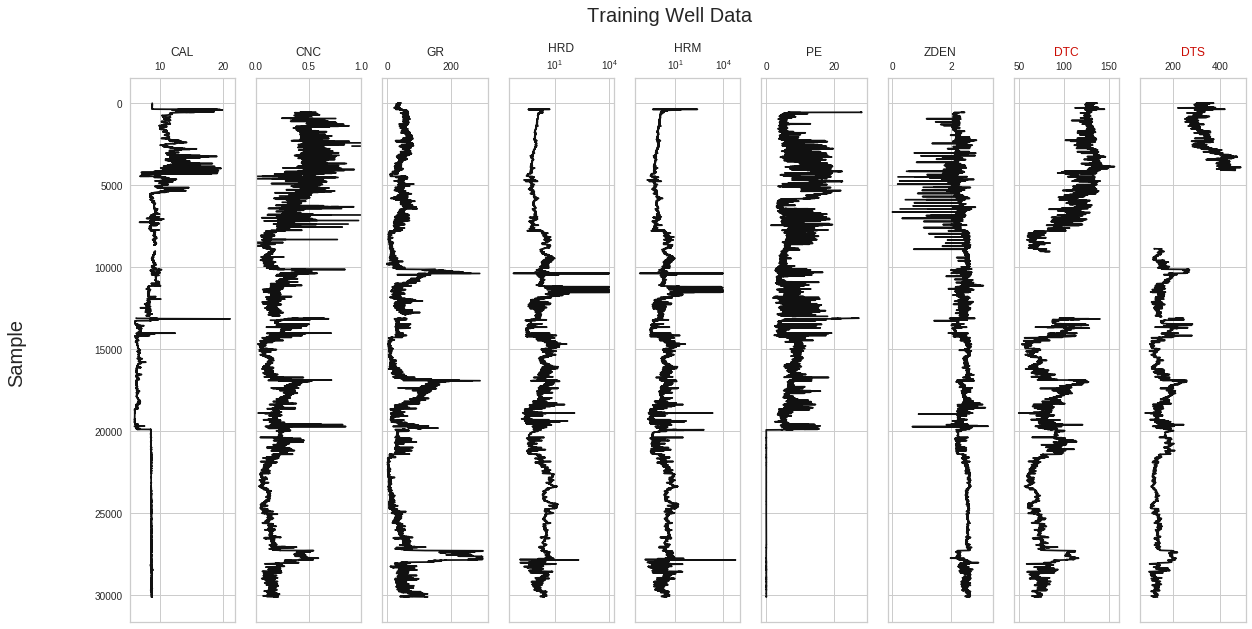

In [39]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Overall, this appears to be better.  The PE final 10,000 values look suspect, though.

**Let's attempt filtering out the spikes remaining in the data.**

The filter first calculates an n-moving window median filtered version of the data and then eliminates values that fall outside of +/- n-standard deviations.

It might make sense to first standardize the data using RobustScaler (uses interquartile range 25-75% of the data) and pass the standardized data to the filter.

After filter, the data can be transformed back to its non-standardized domain.

In [ ]:
rs = RobustScaler()
scaled_features = rs.fit_transform(df_w1.values)
scaled_features_df = pd.DataFrame(data=scaled_features, index=df_w1.index, columns=df_w1.columns)

In [ ]:
plot_data_distributions(scaled_features_df.dropna())
plt.show()

In [ ]:
plot_well_curves(scaled_features_df)
plt.show()

Pass the scaled data to the filter and then backtransform the filtered data

In [ ]:
df_clean_scaled, df_outliers_scaled = filter_curves(scaled_features_df, 81, 2)

# Backtransform the cleaned data & outliers to the unscaled domain
clean_unscaled = rs.inverse_transform(df_clean_scaled.values)
df_clean = pd.DataFrame(data=clean_unscaled, columns=df_w1.columns)
outliers_unscaled = rs.inverse_transform(df_outliers_scaled.values)
df_outliers = pd.DataFrame(data=outliers_unscaled, columns=df_w1.columns)

In [ ]:
df_w1.describe().transpose()

In [ ]:
df_clean.describe().transpose()

In [ ]:
#cleaned_fig = plot_well_curves(df_clean)
cleaned_fig = plot_well_curves(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

In [ ]:
#qc_fig = qc_curve_filt(df_w1, df_clean)
qc_fig = qc_curve_filt(df_w1, df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
#qc_fig = qc_curve_filt(df_w1, df_clean, df_outliers)
plt.show()

**At this point, it seems prudent to make some plots comparing our final cleaned curves to established rock property trends as a QC of the imputation and filtering**

Use plot_vp_vs to plot the imputed data against well known lithology trends, first the *pre-imputation* data ...

In [ ]:
plot_vp_vs(x='DTC', y='DTS', df=df_clean)
plt.show()

**A few observations:**

1. Limestone appears to be a significant lithology.

1. Shale / Claystone also appear to be present throughout the well.

1. Sands are present.  Some sands may be difficult to discriminate in the overlap zone between Shale, Sand, & Limestone lines.  Gas-charged sands fall below the water-saturated sandstone line.

1. There may be a minor amount of dolomite present in the system.

1. Vp & Vs trends are obviously dependent upon lithology.  Plotting all of the data together, there is obvious heteroscedasticity.  Linear models would not fare well directly predicting Vs from Vp.  However, by using other features which are sensitive to lithologic variations, we should be able to build a robust model to handle these challenges.

**CAL seems a little suspect, though.  It seems unusual for CAL to increase at the bottom of the hole**

In fact, CAL and PE basically go bad at the same sample number, so it is likely they had a shared tool failure

There are several ways to proceed.

A few observations:

* CAL could be useful (variations in the wellbore are related to geomechanical properties), but it can also be rather stationary.
* If we want to maximize the amount of data available for estimating DTC & DTS, then interpolation is necessary.
* The last 10,000 samples in the PE curve appear to be bogus.  Maybe these can be estimated using the shallower section?
* HRM (Medium Resisitivity) should be dropped.  Without knowing the depth of investigation, it is likely to be contaminated with well-bore fluids.  HRD (Deep Resisitivity) is the better resistivity curve to use.  Maybe we could calculate Rt?

In [ ]:
plt.rcParams["axes.labelsize"] = 20

In [ ]:
sns.pairplot(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

Several predictors exhibit a degree of multicollinearity

* CNC & GR, which also exhibits heteroscedasticity
* CNC & ZDEN
* HRM & HRD

Feature ranking will be an important step

PCA may also be useful

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False).corr(), cmap="RdBu_r", annot=True, fmt=".2f")
ax.set_title('Correlation Coefficient Heatmap of Well Log Curves')
plt.show()

Observations:

* CAL has reasonably high positive correlation to both DTC & DTS, as well as CNC.
* CNC has reasonably high positive correlation to CAL, GR, PE, as well as to DTC & DTS
* GR has moderate positive correlation to DTC & DTS
* HRD & HRM do not exhibit strong correlation with any other parameters than themselves, *but this could be due to the fact they are log-scale*
* PE has moderately positive correlation with CNC, DTC, & DTS
* ZDEN has a high negative correlation with CNC, DTC, & DTS, and mild negative correlation with CAL, GR, & PE

The recommendation going forward will be to drop CAL & HRM from the set of inputs.